# Colab Setup

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
"""
Change directory to where this file is located
"""
%cd /content/drive/MyDrive/AI/VIP Lab/homework2

/content/drive/MyDrive/AI/VIP Lab/homework2


# Import Modules

In [20]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets.cifar10 import load_data

In [21]:
"""
import modules you need

"""
import scipy
import math
from tensorflow.keras import models, regularizers

In [22]:
"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Utils

In [6]:
def plot_dataset(images, labels, grid_width, grid_height, figure_width=5, figure_height=5, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this method.
    """
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = InputPipelineBuilder.LABELS[label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(image, aspect='auto')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

def plot_history(history):
    """
    Plots training history.

    Do NOT modify this method.
    """
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# CIFAR-10 Data Augmentation

In [7]:
class InputPipelineBuilder:
    """
    CIFAR10 Input Pipeline
    """
    IMG_SIZE = (32,32)
    LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def __init__(self, valid_size=0.2):
        """
        Loads and splits CIFAR10 to train, validation, and test sets.

        Do NOT modify this method.
        """
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_size)
        self.x = {'train':x_train, 'valid':x_valid, 'test':x_test}
        self.y = {'train':y_train, 'valid':y_valid, 'test':y_test}

    def get_dataset(self, generator, subset='train'):
        """
        Creates a tf.dataset to load input images augmented by the given generator.

        Do NOT modify this method.
        """
        x = self.x[subset]
        y = self.y[subset]
        def gen():
            for images, labels in generator.flow(x, y, batch_size=1, shuffle=False):
                yield images[0], labels[0]
        ds = tf.data.Dataset.from_generator(
            gen,
            output_signature=(
                tf.TensorSpec(shape=(*InputPipelineBuilder.IMG_SIZE, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(1,), dtype=tf.float32)))
        return ds, len(y)

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, filter_size=3, sigma=1.0, prob=0.5, augment=True, **kwargs):
        """
        Inherits TF Image Data Generator for random gaussian smoothing.

        Do NOT modify this method.

        Inputs
        - filter_size
        - sigma
        - prob: a probability to apply gaussian smoothing.
        """
        if augment:
            super(CustomImageDataGenerator, self).__init__(preprocessing_function=self.random_gaussian_smoothing, **kwargs)
        else:
            super(CustomImageDataGenerator, self).__init__(preprocessing_function=None, **kwargs)
        self.filter_size = filter_size
        self.sigma = sigma
        self.prob = prob

    def random_gaussian_smoothing(self, image):
        """
        Apply random Gaussian smoothing to the given image.

        Do NOT modify this method.

        Inputs
        - image
        Returns
        - image: augmented image.
        """
        apply = np.random.binomial(1, self.prob)
        if apply:
            return self.gaussian_smoothing(image)
        else:
            return image

    def gaussian_smoothing(self, image):
        """
        Creates a Gaussian filter and applies smoothing to the given image.

        Question (a)
        - You may not use libraries to directly achieve a Gaussian filter.  # cv2.getGaussianKernel 사용 금지
        - Use self.filter_size and self.sigma to define the filter.
        - Use cv2.filter2D(image, -1, gaussian_filter) for convolution.

        Inputs
        - image: an input image of shape (32,32,3).
        Returns
        - image: image blurred with a Gaussian Filter.
        """
        # 2D Gaussian Filter
        array = np.arange((self.filter_size//2)*(-1), (self.filter_size//2)+1) # 중심에서부터의 거리

        arr = np.zeros((self.filter_size, self.filter_size)) # 행렬 초기화
        for x in range(self.filter_size):
          for y in range(self.filter_size):
            arr[x, y] = array[x]**2 + array[y]**2

        gaussian_filter = np.zeros((self.filter_size, self.filter_size)) # 행렬 초기화
        for x in range(self.filter_size):
          for y in range(self.filter_size):
            gaussian_filter[x, y] = np.exp(-arr[x, y]/(2*self.sigma**2)) # 상수 생략

        gaussian_filter /= gaussian_filter.sum() # 필터(=커널)은 전체 합이 1이 되어야 한다.

        image = cv2.filter2D(image, -1, gaussian_filter)

        return image

In [8]:
"""
Builds a CIFAR10 input pipeline, and performs data augmentation for training data.
"""
input_pipeline_builder = InputPipelineBuilder()

train_generator = CustomImageDataGenerator(filter_size=7, sigma=1.0, prob=0.2,
                                           rescale=1./255, zoom_range=0.1, rotation_range=20,
                                           width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
                                           horizontal_flip=True, fill_mode='nearest')
valid_generator = CustomImageDataGenerator(rescale=1./255, augment=False)
test_generator = CustomImageDataGenerator(rescale=1./255, augment=False)

170498071/170498071 [==============================] - 6s 0us/step


In [9]:
"""
Utilize TF dataset methods to expedite I/O.
"""
batch_size = 64

train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds = train_ds_preprocessed.shuffle(1000).batch(16)
valid_ds = valid_ds_preprocessed.batch(16)

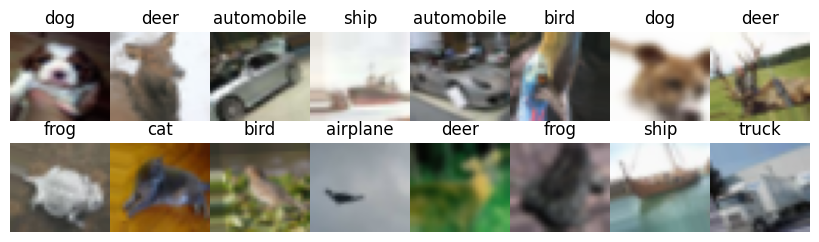

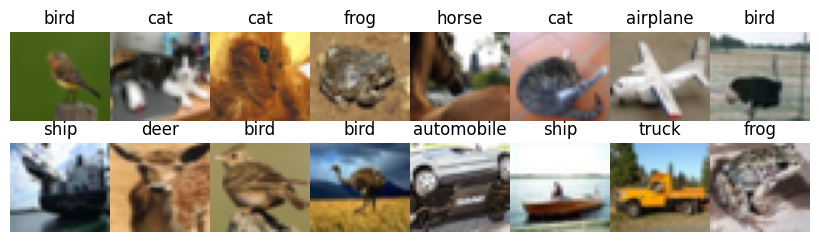

In [10]:
images, labels = next(iter(train_ds.take(1)))
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=8, figure_height=2)
images, labels = next(iter(valid_ds.take(1)))
plot_dataset(images, labels, grid_width=8, grid_height=2, figure_width=8, figure_height=2)

# ConvNet Image Classification

In [37]:
def ConvNet(input_shape=(32,32,3)):
    """
    Builds a ConvNet model.
    The model must include BatchNormalization, regularizer, and Dropout.

    Question (b)
    - things that might be useful...
    - stack [Conv2D + Conv2D + MaxPool2D] three times.
    - each Conv2D layer uses filter size = 3x3, kernel_initializer='he_uniform', padding='same'.
      (add more parameters to Conv2D if necessary!)
    - follwed by two Dense layers.
    - channels or units used: [32, 32, 64, 64, 128, 128, 128, 10]
    - The model must include BatchNormalization, regularizers, and Dropout.

    Inputs
    - input_shape: the shape of the input image.
    Returns
    - cnn: a TF Keras Sequential model of ConvNet
    """

    l2_factor = 0.001
    dropout_factor = 0.5

    cnn = tf.keras.Sequential([
        layers.Conv2D(32, (3,3), kernel_initializer='he_uniform', padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_factor)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3,3), kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(2,2),

        layers.Conv2D(64, (3,3), kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3,3), kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(2,2),

        layers.Conv2D(128, (3,3), kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3,3), kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l2_factor)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(2,2),

        layers.Flatten(),
        layers.Dropout(dropout_factor),
        layers.Dense(128, kernel_regularizer=regularizers.l2(l2_factor)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(l2_factor))
    ])

    # 확인용
    print(cnn.summary())

    return cnn

In [ ]:
###
# Question (c)
# Train your ConvNet to achieve test accuracy above 60%
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
###


In [38]:
"""
Utilize TF dataset methods to expedite I/O.
"""
batch_size = 64

train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds, train_steps = train_ds_preprocessed.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE), train_steps//batch_size
valid_ds, valid_steps = valid_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), valid_steps//batch_size
test_ds, test_steps = test_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), test_steps//batch_size

In [39]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

cnn = ConvNet()
cnn.compile(optimizer, loss, metrics=metric)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_35 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_35 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_36 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 32, 32, 32)       

In [40]:
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/20
625/625 [==============================] - 57s 82ms/step - loss: 2.5057 - sparse_categorical_accuracy: 0.4436 - val_loss: 2.0576 - val_sparse_categorical_accuracy: 0.5349
Epoch 2/20
625/625 [==============================] - 53s 86ms/step - loss: 1.8455 - sparse_categorical_accuracy: 0.5705 - val_loss: 1.5580 - val_sparse_categorical_accuracy: 0.6279
Epoch 3/20
625/625 [==============================] - 56s 90ms/step - loss: 1.5540 - sparse_categorical_accuracy: 0.6202 - val_loss: 1.3487 - val_sparse_categorical_accuracy: 0.6835
Epoch 4/20
625/625 [==============================] - 61s 98ms/step - loss: 1.4207 - sparse_categorical_accuracy: 0.6490 - val_loss: 1.2152 - val_sparse_categorical_accuracy: 0.7203
Epoch 5/20
625/625 [==============================] - 61s 98ms/step - loss: 1.3419 - sparse_categorical_accuracy: 0.6703 - val_loss: 1.1651 - val_sparse_categorical_accuracy: 0.7321
Epoch 6/20
625/625 [==============================] - 57s 92ms/step - loss: 1.2942 - spars

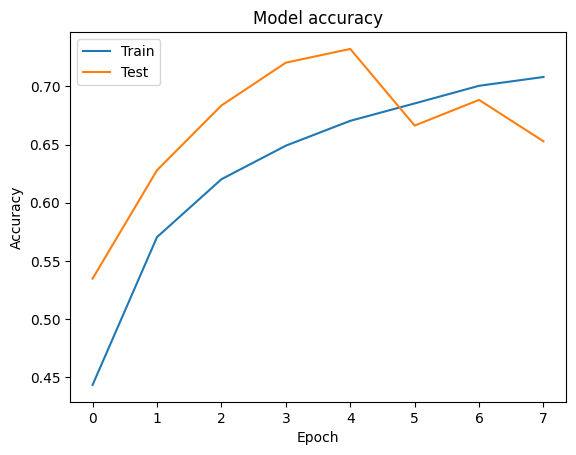

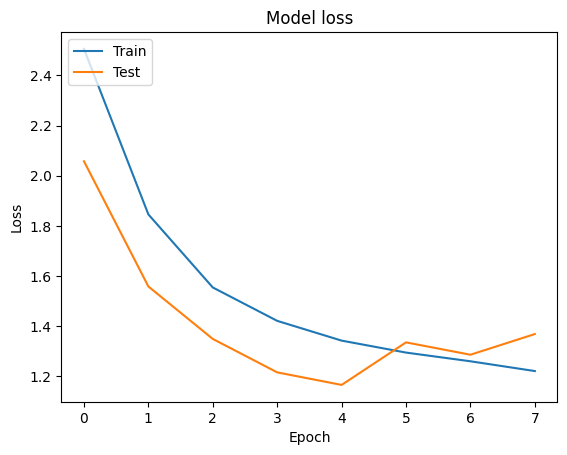

In [41]:
history = cnn.fit(train_ds,
                  steps_per_epoch=train_steps,
                  validation_data=valid_ds,
                  validation_steps=valid_steps,
                  callbacks=callbacks,
                  epochs=20,
                  verbose=1)

plot_history(history)

1/1 [==============================] - 0s 157ms/step


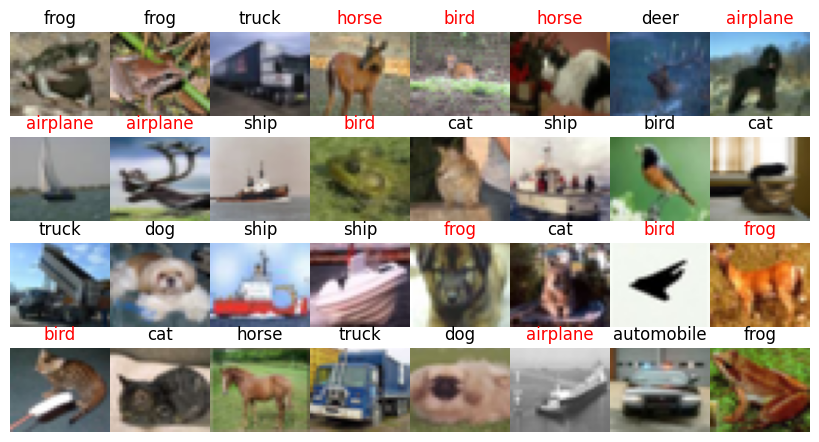

In [42]:
"""
Measure test accuracy
"""
cnn.evaluate(test_ds, steps=test_steps)

images, labels = next(iter(test_ds_preprocessed.shuffle(100).batch(32).take(1)))
y_hats = np.argmax(cnn.predict(images), axis=1)
plot_dataset(images, labels, grid_width=8, grid_height=4, figure_width=8, figure_height=4, y_hats=y_hats)

# ResNet50 Transfer Learning

In [23]:
def conv_block(input_tensor, kernel_size, filters, strides=1, conv_shortcut=False):
    """
    a building block for ResNet50 implemented with TF Keras Functional API.

    Question (d)
    - consists of three [Conv2D+BN]s and a shortcut.
    - if a shortcut needs to match dimensions, apply Conv2D+BN to input_tensor.
    - otherwise, a shortcut is just input_tensor.
    - refer to the figure 2 in the pdf file to place ReLUs.

    Inputs
    - input_tensor: input tensor.
    - kernel_size: filter size
    - filters: a list of the numbers of channels; e.g. [9, 16, 25]
    - strides
    - conv_shortcut: indicates whether a shortcut connection uses a Conv2D.
    Returns
    - x: output tensor
    """

    x = layers.Conv2D(filters=filters[0], kernel_size=1, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=filters[1], kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=filters[2], kernel_size=1,  strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if conv_shortcut:
      shortcut = layers.Conv2D(filters=filters[2], kernel_size=1,  strides=strides, padding='same')(input_tensor)
      shortcut = layers.BatchNormalization()(shortcut)

    else:
      shortcut = input_tensor

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)

    return x


def ResNet50(input_shape=(224,224,3)):
    """
    Builds a ResNet50 model.

    Question (d)
    - complete the model from conv2_x to conv5_x.
    - refer to the figure 2 for the overall architecture.

    Inputs
    - input_shape: the shape of the input image.
    Returns
    - a TF Keras Model model of ResNet50
    """
    # input layer
    input_tensor = Input(shape=input_shape)

    # conv1
    x = layers.ZeroPadding2D(padding=(3, 3))(input_tensor)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)

    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    # conv2_x
    # input_tensor, kernel_size, filters, strides=1, conv_shortcut=False) 인자 리스트 참고
    x = conv_block(x, 3, [64, 64, 256], strides=1, conv_shortcut=True)
    for i in range(2, 4):
      x = conv_block(x, 3, [64, 64, 256], strides=1)

    # conv3_x
    x = conv_block(x, 3, [128, 128, 512], strides=2, conv_shortcut=True)
    for i in range(2, 5):
      x = conv_block(x, 3, [128, 128, 512], strides=1)


    # conv4_x
    x = conv_block(x, 3, [256, 256, 1024], strides=2, conv_shortcut=True)
    for i in range(2, 7):
      x = conv_block(x, 3, [256, 256, 1024], strides=1)


    # conv5_x
    x = conv_block(x, 3, [512, 512, 2048], strides=2, conv_shortcut=True)
    for i in range(2, 4):
      x = conv_block(x, 3, [512, 512, 2048], strides=1)


    return tf.keras.Model(input_tensor, x)

In [25]:
###
# Load pretrained weights on ImageNet.
# Use this line to verify your implementation of ResNet50 ***
# If your implementation is right, the model should be able to load the weights.
###

Input = layers.Input # 추가

base = ResNet50()
print(base.summary()) # 추가
base.load_weights('./pretrained/resnet50_weights_imagenet.h5', by_name=True) # 중간에 오류 발생으로, 스택플로우 서칭 결과 by_name 추가로 해결

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_10 (ZeroPad  (None, 230, 230, 3)          0         ['input_6[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv2d_216 (Conv2D)         (None, 112, 112, 64)         9472      ['zero_padding2d_10[0][0]']   
                                                                                                  
 batch_normalization_216 (B  (None, 112, 112, 64)         256       ['conv2d_216[0][0]']    

In [26]:
tf.keras.backend.clear_session()

inputs = Input(shape=[32,32,3])
x = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)
resnet = tf.keras.Model(inputs, outputs)

In [ ]:
###
# Question (e)
# Train your ResNet50 to achieve test accuracy above 90%
# You can try or add other training options such as Adam or callbacks to schedule learning rates if you want.
###

In [27]:
"""
Utilize TF dataset methods to expedite I/O.
"""
batch_size = 64

train_ds_preprocessed, train_steps = input_pipeline_builder.get_dataset(train_generator, subset='train')
valid_ds_preprocessed, valid_steps = input_pipeline_builder.get_dataset(valid_generator, subset='valid')
test_ds_preprocessed, test_steps = input_pipeline_builder.get_dataset(test_generator, subset='test')

train_ds, train_steps = train_ds_preprocessed.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE), train_steps//batch_size
valid_ds, valid_steps = valid_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), valid_steps//batch_size
test_ds, test_steps = test_ds_preprocessed.batch(64).prefetch(tf.data.experimental.AUTOTUNE), test_steps//batch_size

In [36]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

resnet.compile(optimizer, loss, metrics=metric)

In [40]:
callbacks = []
# callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/10
625/625 [==============================] - 413s 659ms/step - loss: 0.9756 - sparse_categorical_accuracy: 0.6531 - val_loss: 1.1815 - val_sparse_categorical_accuracy: 0.6039
Epoch 2/10
625/625 [==============================] - 412s 659ms/step - loss: 0.9260 - sparse_categorical_accuracy: 0.6740 - val_loss: 0.9244 - val_sparse_categorical_accuracy: 0.6720
Epoch 3/10
625/625 [==============================] - 412s 659ms/step - loss: 0.8955 - sparse_categorical_accuracy: 0.6801 - val_loss: 1.0403 - val_sparse_categorical_accuracy: 0.6413
Epoch 4/10
625/625 [==============================] - 412s 659ms/step - loss: 0.8592 - sparse_categorical_accuracy: 0.6975 - val_loss: 0.9618 - val_sparse_categorical_accuracy: 0.6644
Epoch 5/10
625/625 [==============================] - 412s 659ms/step - loss: 0.8239 - sparse_categorical_accuracy: 0.7076 - val_loss: 1.3404 - val_sparse_categorical_accuracy: 0.5727
Epoch 6/10
625/625 [==============================] - 398s 636ms/step - loss: 0.

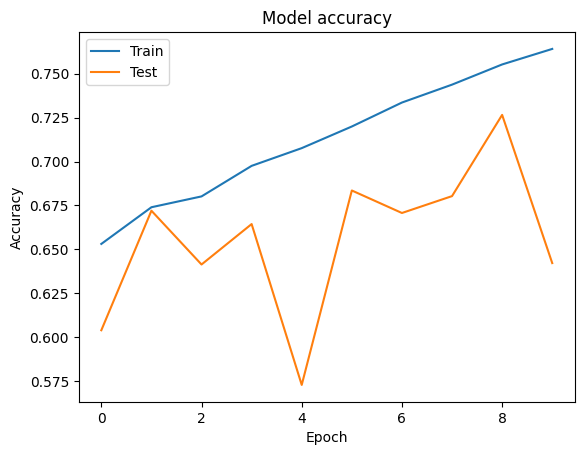

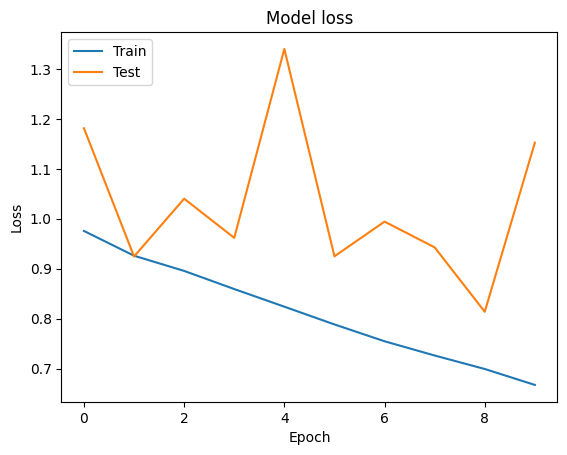

In [41]:
history = resnet.fit(train_ds,
                     steps_per_epoch=train_steps,
                     validation_data=valid_ds,
                     validation_steps=valid_steps,
                     callbacks=callbacks,
                     epochs=10,
                     verbose=1)
plot_history(history)

Epoch 1/5
625/625 [==============================] - 413s 658ms/step - loss: 0.6447 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.7512
Epoch 2/5
625/625 [==============================] - 411s 658ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.7833 - val_loss: 0.6636 - val_sparse_categorical_accuracy: 0.7705
Epoch 3/5
625/625 [==============================] - 412s 658ms/step - loss: 0.6024 - sparse_categorical_accuracy: 0.7922 - val_loss: 0.7756 - val_sparse_categorical_accuracy: 0.7387
Epoch 4/5
625/625 [==============================] - 398s 636ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.7936 - val_loss: 0.9178 - val_sparse_categorical_accuracy: 0.7164
Epoch 5/5
625/625 [==============================] - 397s 635ms/step - loss: 0.5631 - sparse_categorical_accuracy: 0.8045 - val_loss: 0.5681 - val_sparse_categorical_accuracy: 0.8018


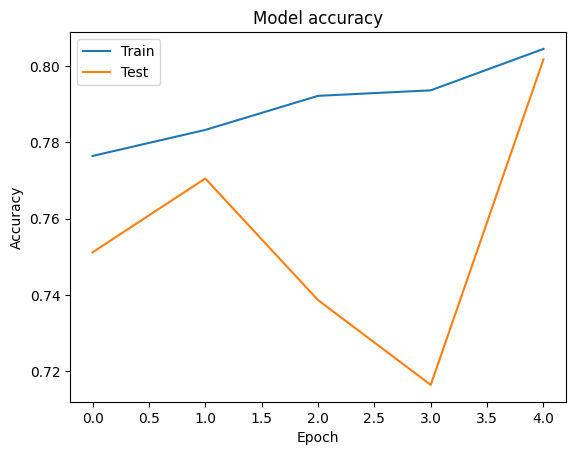

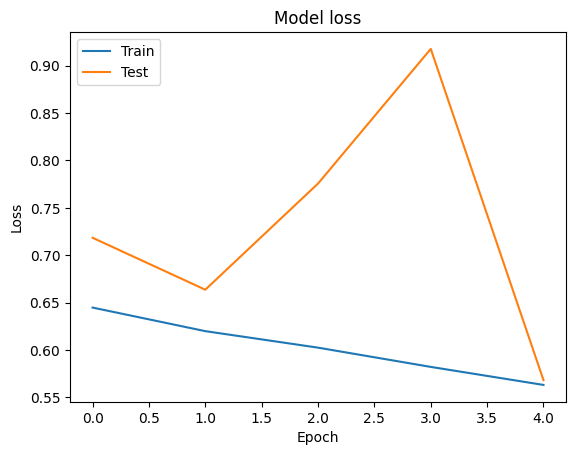

In [42]:
history = resnet.fit(train_ds,
                     steps_per_epoch=train_steps,
                     validation_data=valid_ds,
                     validation_steps=valid_steps,
                     callbacks=callbacks,
                     epochs=5,
                     verbose=1)
plot_history(history)

Epoch 1/5
625/625 [==============================] - 413s 659ms/step - loss: 0.5466 - sparse_categorical_accuracy: 0.8068 - val_loss: 0.7138 - val_sparse_categorical_accuracy: 0.7600
Epoch 2/5
625/625 [==============================] - 398s 636ms/step - loss: 0.5310 - sparse_categorical_accuracy: 0.8140 - val_loss: 0.6093 - val_sparse_categorical_accuracy: 0.7922
Epoch 3/5
625/625 [==============================] - 411s 658ms/step - loss: 0.5104 - sparse_categorical_accuracy: 0.8237 - val_loss: 0.7423 - val_sparse_categorical_accuracy: 0.7624
Epoch 4/5
625/625 [==============================] - 412s 659ms/step - loss: 0.4957 - sparse_categorical_accuracy: 0.8280 - val_loss: 0.6453 - val_sparse_categorical_accuracy: 0.7908
Epoch 5/5
625/625 [==============================] - 411s 658ms/step - loss: 0.4834 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.5549 - val_sparse_categorical_accuracy: 0.8126


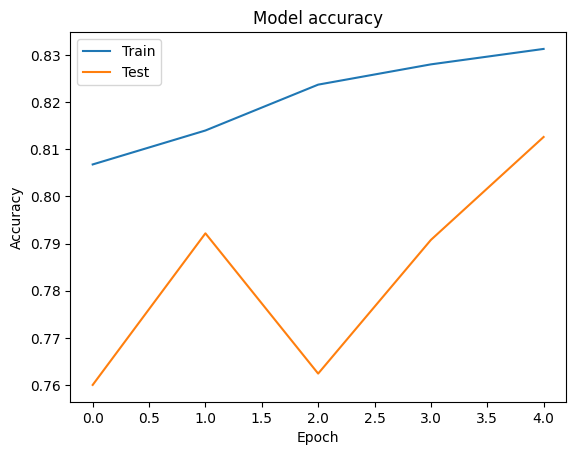

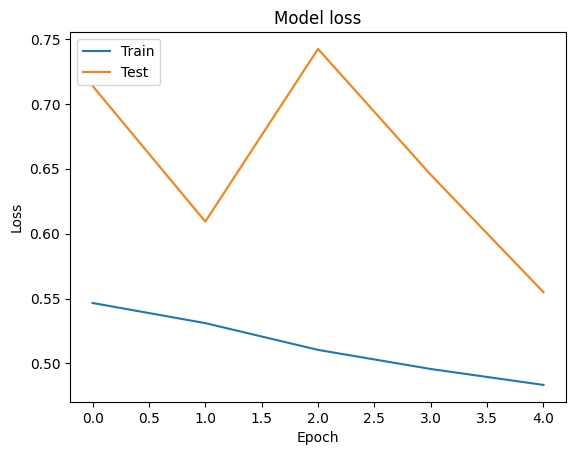

In [43]:
history = resnet.fit(train_ds,
                     steps_per_epoch=train_steps,
                     validation_data=valid_ds,
                     validation_steps=valid_steps,
                     callbacks=callbacks,
                     epochs=5,
                     verbose=1)
plot_history(history)

Epoch 1/10
625/625 [==============================] - 413s 659ms/step - loss: 0.4742 - sparse_categorical_accuracy: 0.8350 - val_loss: 0.6394 - val_sparse_categorical_accuracy: 0.7851
Epoch 2/10
625/625 [==============================] - 397s 636ms/step - loss: 0.4498 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.5320 - val_sparse_categorical_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 397s 636ms/step - loss: 0.4429 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.5919 - val_sparse_categorical_accuracy: 0.8095
Epoch 4/10
625/625 [==============================] - 397s 636ms/step - loss: 0.4256 - sparse_categorical_accuracy: 0.8493 - val_loss: 0.6153 - val_sparse_categorical_accuracy: 0.8040
Epoch 5/10
625/625 [==============================] - 397s 636ms/step - loss: 0.4166 - sparse_categorical_accuracy: 0.8528 - val_loss: 0.5977 - val_sparse_categorical_accuracy: 0.8049
Epoch 6/10
625/625 [==============================] - 397s 635ms/step - loss: 0.

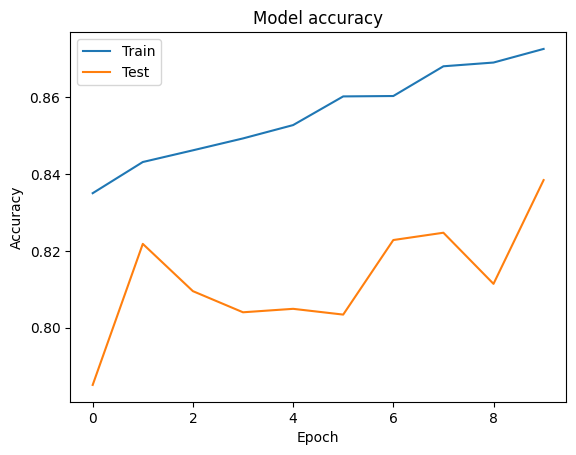

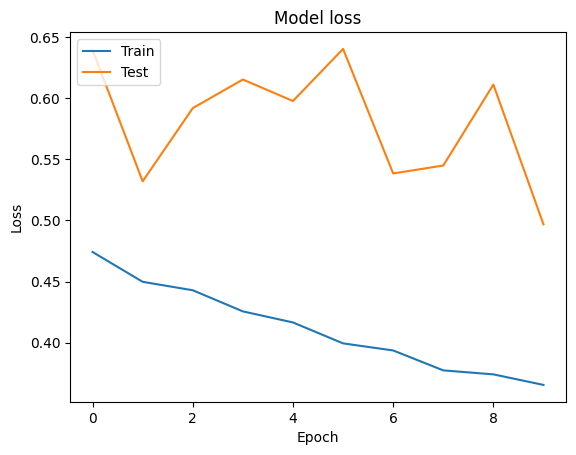

In [44]:
history = resnet.fit(train_ds,
                     steps_per_epoch=train_steps,
                     validation_data=valid_ds,
                     validation_steps=valid_steps,
                     callbacks=callbacks,
                     epochs=10,
                     verbose=1)
plot_history(history)

Epoch 1/10
625/625 [==============================] - 408s 650ms/step - loss: 0.3520 - sparse_categorical_accuracy: 0.8779 - val_loss: 0.4920 - val_sparse_categorical_accuracy: 0.8394
Epoch 2/10
625/625 [==============================] - 411s 657ms/step - loss: 0.3439 - sparse_categorical_accuracy: 0.8783 - val_loss: 0.5446 - val_sparse_categorical_accuracy: 0.8290
Epoch 3/10
625/625 [==============================] - 412s 659ms/step - loss: 0.3382 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.6391 - val_sparse_categorical_accuracy: 0.8060
Epoch 4/10
625/625 [==============================] - 412s 659ms/step - loss: 0.3279 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.5216 - val_sparse_categorical_accuracy: 0.8403
Epoch 5/10
625/625 [==============================] - 412s 659ms/step - loss: 0.3164 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.8142
Epoch 6/10
625/625 [==============================] - 398s 636ms/step - loss: 0.

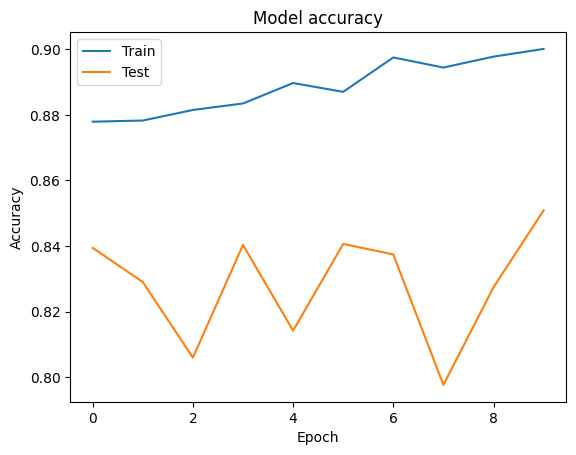

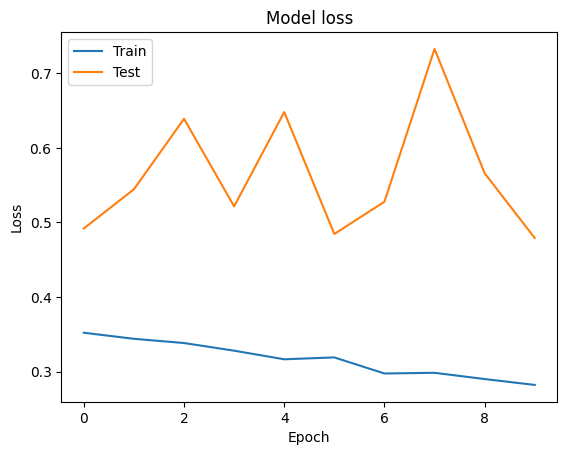

In [46]:
history = resnet.fit(train_ds,
                     steps_per_epoch=train_steps,
                     validation_data=valid_ds,
                     validation_steps=valid_steps,
                     callbacks=callbacks,
                     epochs=10,
                     verbose=1)
plot_history(history)

종합적으로 **총 50 에포크 훈련**, 추가적으로 훈련시켜도 더 성능이 잘 나오지 않는 것 같아 이대로 제출합니다.

1/1 [==============================] - 0s 35ms/step


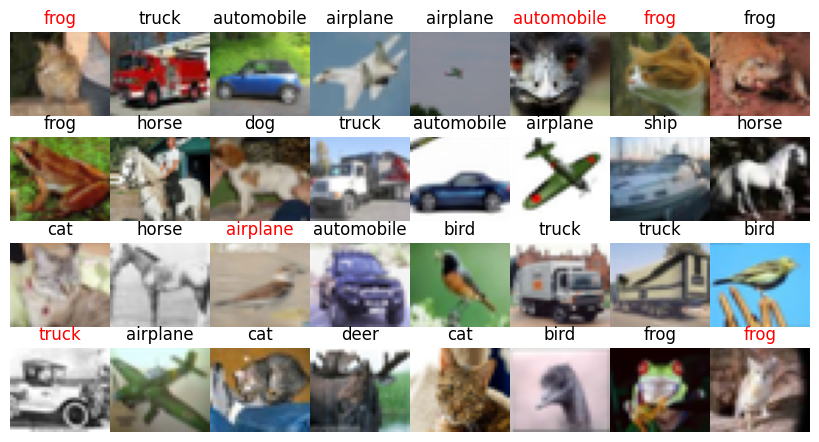

In [47]:
"""
Measure test accuracy
"""
resnet.evaluate(test_ds, steps=test_steps)

images, labels = next(iter(test_ds_preprocessed.shuffle(100).batch(32).take(1)))
y_hats = np.argmax(resnet.predict(images), axis=1)
plot_dataset(images, labels, grid_width=8, grid_height=4, figure_width=8, figure_height=4, y_hats=y_hats)